<a href="https://colab.research.google.com/github/YI-CHENG-SHIH645/ML-in-Business_practice/blob/main/ch2_unsupervised-learning/ch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Imports
!gdown --id "15p2cUU3ocPUDDS9tGmhNos05dSyJFd2A"
!pip install FinMind

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from utils import DataLoader, display_side_by_side
import seaborn as sns
from matplotlib import style
style.use('dark_background')

scaler = StandardScaler()

Downloading...
From: https://drive.google.com/uc?id=15p2cUU3ocPUDDS9tGmhNos05dSyJFd2A
To: /content/utils.py
100% 7.29k/7.29k [00:00<00:00, 11.7MB/s]


In [ ]:
df = DataLoader.load_data('country_risk_url')
df.head()

,Country,Abbrev,Corruption,Peace,Legal,GDP Growth
0,Albania,AL,39,1.867,3.822,3.403
1,Algeria,DZ,34,2.213,4.160,4.202
2,Argentina,AR,36,1.957,4.568,-2.298
3,Armenia,AM,33,2.218,4.126,0.208
4,Australia,AU,79,1.465,8.244,2.471


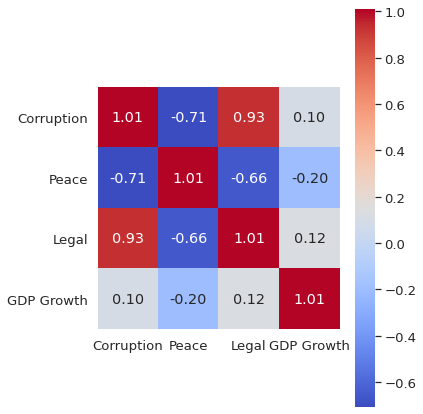

In [ ]:
#@title correlation between features
cols = df.columns[2:6]
cov_matrix = np.cov(StandardScaler().fit_transform(df[cols]).T)

def draw_cov_heatmap(cov_matrix, cols):
    plt.figure(figsize=(6,6), facecolor='w')
    sns.set(font_scale=1.2)
    hm = sns.heatmap(cov_matrix,
                    cmap='coolwarm',
                    annot=True,
                    square=True,
                    fmt='.2f',
                    yticklabels=cols,
                    xticklabels=cols)
    plt.tight_layout()
    plt.show()

draw_cov_heatmap(cov_matrix, cols)

# k-Means

*   Choosing k
    *   elbow method
    *   silhouette method

*   re-run (local minimum problem)

In [ ]:
original_input = df[['Peace', 'Legal', 'GDP Growth']]

In [ ]:
#@title kmeans 3 clusters without scaled input
#@markdown 分群後需自行解讀合理的 risk level (low, high)
kmeans = KMeans(n_clusters=3, random_state=3).fit(original_input)
pd.DataFrame(kmeans.cluster_centers_, columns=original_input.columns, index=['low', 'moderate', 'high'])

,Peace,Legal,GDP Growth
low,1.926408,6.023474,1.748632
moderate,2.071300,5.019375,5.079650
high,2.532667,4.083667,-7.771500


performance measurement
*   Inertia
>$Inertia=\sum_{i}\sum_{j} (d_{j} - m_{i})^2$, where $d_j \in ith$ cluster
*   average silhouette score = $\frac{1}{N}\sum_i s(i)$
>$s(i)=\frac{b(i) - a(i)}{max(b(i), a(i))}$, $s(i) \in [-1, 1]$

In [ ]:
round(silhouette_score(original_input, kmeans.labels_), 3)

0.37

In [ ]:
scaled_input = scaler.fit_transform(original_input)

In [ ]:
#@title kmeans 3 clusters with scaled input
kmeans_scaled = KMeans(n_clusters=3, random_state=3).fit(scaled_input)
pd.DataFrame(kmeans_scaled.cluster_centers_, columns=original_input.columns, index=['high', 'low', 'moderate'])

,Peace,Legal,GDP Growth
high,1.397830,-1.046003,-1.801892
low,-0.931933,1.171223,-0.014518
moderate,0.260407,-0.473601,0.379518


In [ ]:
round(silhouette_score(scaled_input, kmeans_scaled.labels_), 3)

0.387

In [ ]:
category = {0: "high", 1: "low", 2: "moderate"}
kmeans_scaled_str_labels = np.array(list(map(lambda n: category[n], kmeans_scaled.labels_)))
kmeans_scaled_str_labels[:5]

array(['moderate', 'moderate', 'high', 'moderate', 'low'], dtype='<U8')

# The Curse of Dimensionality

In [ ]:
a = np.array([1] * 3)
b = np.array([1.5] * 3)
x = np.array([1] * 10)
y = np.array([1.5] * 10)

d_ab = np.sqrt(((a-b)**2).sum()).round(3)
d_xy = np.sqrt(((x-y)**2)).sum()
print("d_ab =", d_ab)
print("d_xy =", d_xy)

norm_a = np.sqrt((a**2).sum())
norm_b = np.sqrt((b**2).sum())
norm_x = np.sqrt((x**2).sum())
norm_y = np.sqrt((y**2).sum())
simi_ab = (a@b)/(norm_a * norm_b)
simi_xy = (x@y)/(norm_x * norm_y).round(3)

print("simi_dist_ab =", 1-simi_ab)
print("simi_dist_xy =", 1-simi_xy)

d_ab = 0.866
d_xy = 5.0
simi_dist_ab = 0.0
simi_dist_xy = 0.0


# PCA

>什麼樣的向量$w$，可以使得所有data point投影上去後訊息損失(information loss)最低 <br>
lower information loss -> higher variance kept<br>

>given任意n維的vector，皆能被某個basis $W$ (n個components, orthogonal to each other)的線性組合唯一表示(zero loss) <br> 如果只用幾個component，就會有loss <br>
線性組合的 scalars 怎麼找？ -> 投影長 = ${\lVert x \rVert}cos{\theta}, $ where ${\theta}$ 為 x 和 w 的夾角 <br>
under constraint： <br>
>>${\lVert w_{n} \rVert} = 1$<br>

>投影長 = $scalar_{n,i} = w_{n} \cdot x_{i}$ <br>
先找一個component就好，使得variance最大，objective funciton？<br>
$Objective$ = 投影長的variance = $\sum_{i} (w_{1} \cdot x_{i} - w_{1} \cdot \bar x)^2$
......<br>...... $w_{1}$ 是 Cov(x) 的最大 eigenvalue(其值為所求的variance) 對應的 eigenvector <br> 這樣的 $w_{1}$(the most dominant pattern) 可以 maximize $Objective$

>那想要找到一組basis呢？ <br>
under constraints：<br>
    >>${\lVert w_{2} \rVert} = 1$<br>
    >>$w_{2} \cdot w_{1} = 0$<br>

>$Objective = \sum_{i} (w_{2} \cdot x_{i} - w_{2} \cdot \bar x)^2$ ......<br>...... $w_{2}$ 是 Cov(x) 第二大 eigenvalue(其值為所求的variance) 對應的 eigenvector <br> 這樣的 $w_{2}$ 可以 maximize $Objective$

> let $W = [w_{1} w_{2} ... w_{k}]$ form a basis, $W^{T}$.shape = (n_components=k, n_features)<br>
let $Z = W^{T}X$, <br>=> X.shape = (n_features, n_samples)<br> => Cov(X).shape = (n_features, n_features) = W.shape = (k, k)<br>
=> Z.shape = (n_components=k, n_samples)<br> => 每個 sample 都有 k個 scalars 用來線性組合回原本的 data x 

>也可以想成 $Z^T = X^TW$<br>

z 是線性組合的 scalar，也是投影長
<br>for the component 1, $Z_{1, m}$ 的 variance 代表投影到這個 component 所保留的 variance (Objective, 其值為 Cov(x) 的 eigenvalues)
<br> for the sample 1, $Z_{n, 1}$ 表示此 data point 轉換到新的 basis $W$ 上的座標


# Singular Value Decomposition

$M = U \sum V^T$ (for any matrix M) <br>
$Z^TW^T = X^T = U \sum V^T$ <br>

$V^T=W^T, Z^T=U\sum$ <br>
$XX^T = V \sum^2V^T => XX^TV = V \sum^2 => V = W$ (economy版的svd, $\sum$ 是 diagonal matrix)<br>
$X^TX = U \sum^2U^T => XX^TU = U \sum^2$ => U is consist of the eigenvectors of $X^TX$ (並不是 samples 間的 covariance matrix)<br>

In [ ]:
data_x = df[['Corruption', 'Peace', 'Legal', 'GDP Growth']]
scaled_input_x = StandardScaler().fit_transform(data_x)
scaled_input_x.shape  # X^T

(122, 4)

In [ ]:
CovX = scaled_input_x.T @ scaled_input_x  # XX^T
eigvals, eigvecs = np.linalg.eig(CovX)
desc_eigvals_arg = np.argsort(eigvals)[::-1]
eigvals, eigvecs = eigvals[desc_eigvals_arg], eigvecs[:, desc_eigvals_arg]
print("explained variance :", eigvals)
print("basis :\n", eigvecs)

explained variance : [312.48251428 118.93717519  47.67032408   8.90998645]
basis :
 [[ 0.59408948 -0.15518449  0.29164029 -0.73343125]
 [-0.53042352 -0.03987563  0.84239087 -0.08624644]
 [ 0.58502332 -0.13456211  0.43097622  0.6737212 ]
 [ 0.15315448  0.9778654   0.13993949 -0.02720102]]


In [ ]:
U, C, VT = np.linalg.svd(scaled_input_x)
U.shape, C.shape, VT.shape

((122, 122), (4,), (4, 4))

$W=V$

In [ ]:
eigvecs

array([[ 0.59408948, -0.15518449,  0.29164029, -0.73343125],
       [-0.53042352, -0.03987563,  0.84239087, -0.08624644],
       [ 0.58502332, -0.13456211,  0.43097622,  0.6737212 ],
       [ 0.15315448,  0.9778654 ,  0.13993949, -0.02720102]])

In [ ]:
VT.T

array([[ 0.59408948, -0.15518449,  0.29164029,  0.73343125],
       [-0.53042352, -0.03987563,  0.84239087,  0.08624644],
       [ 0.58502332, -0.13456211,  0.43097622, -0.6737212 ],
       [ 0.15315448,  0.9778654 ,  0.13993949,  0.02720102]])

In [ ]:
np.allclose(abs(eigvecs), abs(VT.T))

True

$XX^TV = V \sum^2$

In [ ]:
np.allclose(CovX @ VT.T, VT.T @ np.diag(C**2))

True

In [ ]:
np.allclose(np.sqrt(eigvals), C)

True

In [ ]:
pca = PCA(n_components=4)
pca.fit(scaled_input_x)
Z = pca.transform(scaled_input_x)
Z_vars = Z.var(axis=0)

print("explained variance ratio (eigvals):", eigvals[:2].sum()/eigvals.sum())
print("explained variance ratio (Z_vars):", Z_vars[:2].sum()/Z_vars.sum())
print("explained variance ratio (pca):", pca.explained_variance_[:2].sum()/pca.explained_variance_.sum())
print("basis (WT):\n", pca.components_)  # WT = VT

explained variance ratio (eigvals): 0.8840567407211302
explained variance ratio (Z_vars): 0.8840567407211302
explained variance ratio (pca): 0.8840567407211303
basis (WT):
 [[-0.59408948  0.53042352 -0.58502332 -0.15315448]
 [ 0.15518449  0.03987563  0.13456211 -0.9778654 ]
 [ 0.29164029  0.84239087  0.43097622  0.13993949]
 [ 0.73343125  0.08624644 -0.6737212   0.02720102]]


In [ ]:
Z_after_truncation = Z[:, :2]

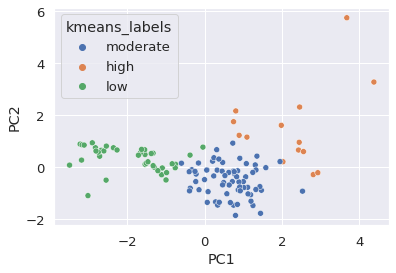

In [ ]:
new_coordinate = pd.DataFrame(Z_after_truncation, columns=['PC1', 'PC2'], index=df['Country'])
new_coordinate_with_kmeans_labels = new_coordinate.copy()
new_coordinate_with_kmeans_labels.insert(2, 'kmeans_labels', kmeans_scaled_str_labels)
sns.scatterplot(x='PC1', y='PC2', data=new_coordinate_with_kmeans_labels, hue='kmeans_labels')
plt.show()

In [ ]:
new_coordinate.values.T @ new_coordinate.values

array([[3.12482514e+02, 5.02197183e-15],
       [5.02197183e-15, 1.18937175e+02]])

In [ ]:
pd.DataFrame(pca.components_[:2], index=['PC1', 'PC2'], columns=data_x.columns)

,Corruption,Peace,Legal,GDP Growth
PC1,-0.594089,0.530424,-0.585023,-0.153154
PC2,0.155184,0.039876,0.134562,-0.977865


In [ ]:
display_side_by_side([new_coordinate[(new_coordinate.PC1 > 4) | (new_coordinate.PC2 > 5)].round(2),
                      new_coordinate[(new_coordinate.PC1 < -2) & (new_coordinate.PC2 < 0)].round(2),
                      new_coordinate[(new_coordinate.PC2 < -1.7)].round(2),
                      new_coordinate[new_coordinate.PC1 < -3.2].round(2)])

,PC1,PC2
Country,,
Venezuela,3.67,5.75
Yemen,4.38,3.28
,PC1,PC2
Country,,
Iceland,-3.01,-1.09
Ireland,-2.55,-0.49
,PC1,PC2
Country,,
Bangladesh,1.44,-1.77


In [ ]:
the_worst_country_ever = [[0., 5, 0., -30.]]
the_best_country_ever = [[100., 1., 10., 30.]]
pca.transform(np.vstack([the_worst_country_ever,
                         the_best_country_ever]))[:, :2]

array([[  7.24675199,  29.53534029],
       [-69.32339227, -12.43201691]])

In [ ]:
of_interest_countries = ['Taiwan', 'China', 'United Kingdom', 'United States',
                        'Italy', 'Spain', 'South Africa', 'Russia']

# ------------------------------------------------------------------------------
risk_measurement = (new_coordinate @ pca.explained_variance_ratio_[:2]).sort_values(ascending=False)
from sklearn.preprocessing import MinMaxScaler
risk_score = (pd.DataFrame(MinMaxScaler().fit_transform(risk_measurement.values.reshape(-1, 1)),
                           index=risk_measurement.index,
                           columns=['risk score']) * 100).round(1)
sorted_idx = risk_score.loc[of_interest_countries].squeeze().sort_values(ascending=False).index
display_side_by_side([risk_score.iloc[:5], 
                      risk_score.iloc[-5:],
                      risk_score.loc[sorted_idx],
                      df.set_index('Country').loc[sorted_idx, data_x.columns]])

,risk score
Country,
Venezuela,100.0
Yemen,97.4
Chad,72.9
Ukraine,67.6
Nigeria,67.2
,risk score
Country,
Finland,6.7
Denmark,6.2


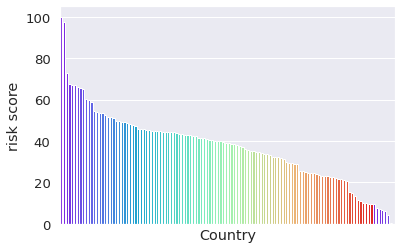

In [ ]:
palette = sns.color_palette('rainbow', n_colors=risk_score['risk score'].unique().size)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
sns.barplot(x='Country', y='risk score', data=risk_score.reset_index(), palette=palette)
plt.show()
palette.reverse()

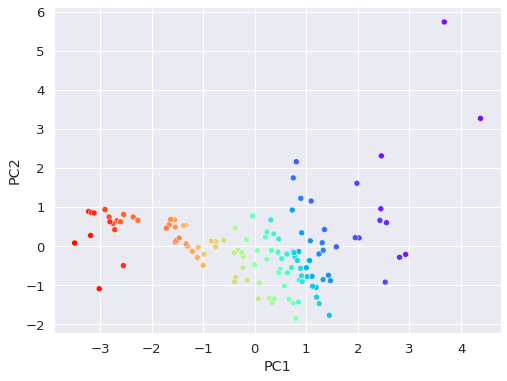

In [ ]:
plt.figure(figsize=(8, 6))
new_coordinate = pd.DataFrame(Z_after_truncation, columns=['PC1', 'PC2'], index=df['Country'])
new_coordinate_with_risk_score = new_coordinate.copy()
new_coordinate_with_risk_score.insert(2, 'risk score', risk_score['risk score'])
sns.scatterplot(x='PC1', y='PC2', data=new_coordinate_with_risk_score, hue='risk score', palette=palette, legend=False)
plt.show()

轉換到一個新的座標系統，PCA(SVD)會找到唯一一個特別的座標系統，將原本的資料換成新的basis的線性組合(matrix factorization)<br>
每個維度依序capture最多的資訊，維度表示特徵(如同原本每個feature也是一個維度，做feature selection就是只認為其中幾個feature有用，什麼叫有用？如果over all samples 該 feature standardized 後的值都很近，就表示沒有參考價值，因為information gain很低)，換了新的basis後每個 component 代表一個 new feature，需重新思考其意義 <br>
 
單取Z的這些投影長，如只取2個維度(Z') => 降維至平面 <br>
Z' 和 basis' 線性組合 => 在原本n維空間中，在此 basis' span 出一個平面上<br>
>Eckart-Young Theorem<br>
${\lVert x- \tilde x \rVert}_{F}$ is minimum under rank($\tilde x$)=2<br>
$\tilde x$ 能最佳近似 $x$ if $\tilde x$ = Z' @ basis'


In [ ]:
x_tilde = Z_after_truncation @ pca.components_[:2]
minimum_reconstruction_error = np.sqrt(((data_x.values - x_tilde)**2).sum())

In [ ]:
minimum_reconstruction_error

553.7080482836009

# agglomerative clustering (bottom up)

1. 每一個 data point 自己一個 cluster
2. 找最近的兩個 clusters 聚為一個 cluster <br>
   cluster間的遠近定義？ 多種可能，以下舉兩個例子 <br>
   average : $dist(C_i, C_j) = \sum_{a \in C_i, b \in C_j}\frac{d(a, b)}{|C_{i}||C_{j}|}$ <br>
   ward : $dist(C_i, C_j) = \sum_{a \in (C_i \cup C_j)} ||a - \mu_{C_i \cup C_j}||^2$
3. 重複 2 直到所有 point 聚為一群



[[ 5.          6.          0.          2.        ]
 [ 2.          7.          0.          2.        ]
 [ 0.          4.          1.          2.        ]
 [ 1.          8.          1.15470054  3.        ]
 [ 9.         10.          2.12132034  4.        ]
 [ 3.         12.          4.11096096  5.        ]
 [11.         13.         14.07183949  8.        ]]


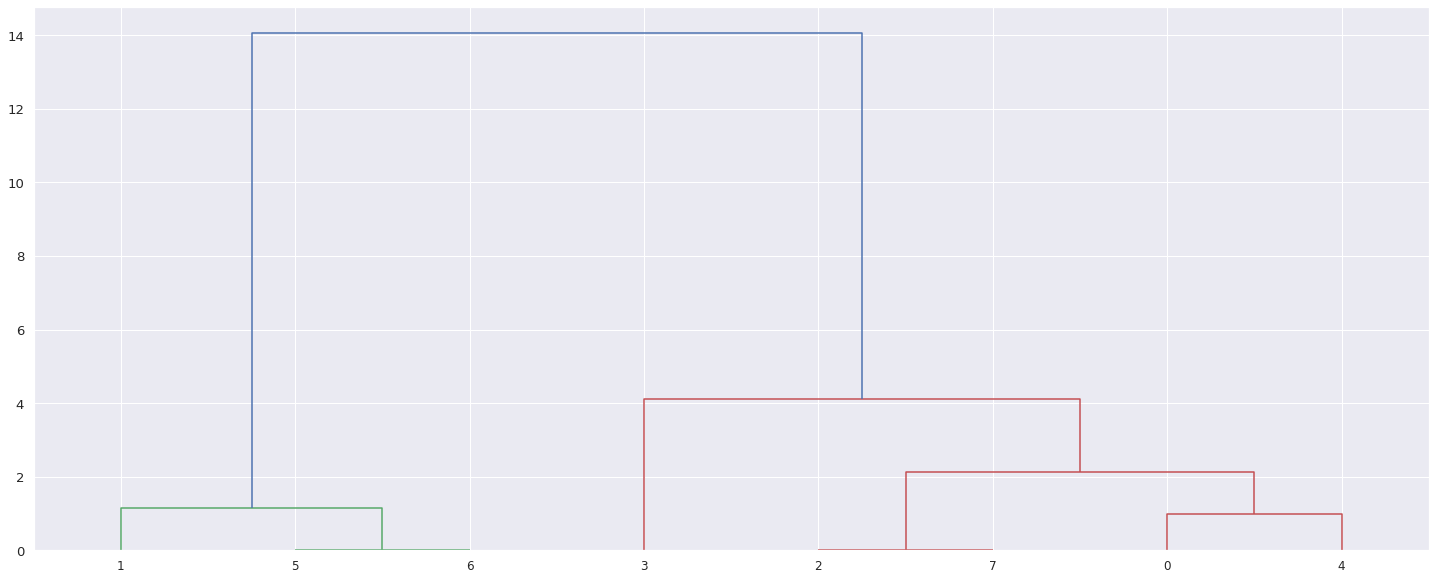

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

X = [[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]]
Z = linkage(X, 'ward')
print(Z)
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

3 features agg,3 features kmeans
,Country
0,-------
1,-------
2,Argentina
3,-------
6,Azerbaijan
7,-------
8,-------
10,-------
11,-------


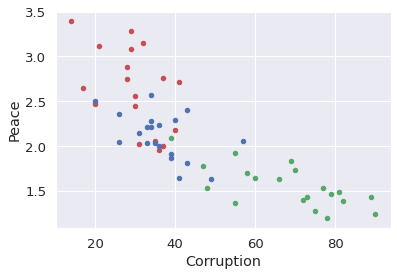

In [ ]:
original_input = df[['Peace', 'Legal', 'GDP Growth']]
scaled_input = scaler.fit_transform(original_input)

agg = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(scaled_input)
three_features_input = df[['Peace', 'Legal', 'GDP Growth']]
three_features_scaled_input = scaler.fit_transform(three_features_input)
kmeans_three_features = KMeans(n_clusters=3, random_state=3).fit(three_features_scaled_input)

ax = plt.gca()
df[agg.labels_==0][:20].plot.scatter(x='Corruption', y='Peace', color='r', ax=ax)
df[agg.labels_==1][:20].plot.scatter(x='Corruption', y='Peace', color='g', ax=ax)
df[agg.labels_==2][:20].plot.scatter(x='Corruption', y='Peace', color='b', ax=ax)


agg_high = df[agg.labels_==0][['Country']]
kmeans_high = df[kmeans_three_features.labels_ == 2][['Country']]
for idx in kmeans_high.index.difference(agg_high.index):
    agg_high.loc[idx, 'Country'] = '-------'
for idx in agg_high.index.difference(kmeans_high.index):
    kmeans_high.loc[idx, 'Country'] = '-------'
display_side_by_side([agg_high.sort_index(), kmeans_high.sort_index()],
                      names=['3 features agg', '3 features kmeans'])



,Country,Abbrev,Corruption,Peace,Legal,GDP Growth
119,Yemen,YE,14,3.399,2.728,-9.779


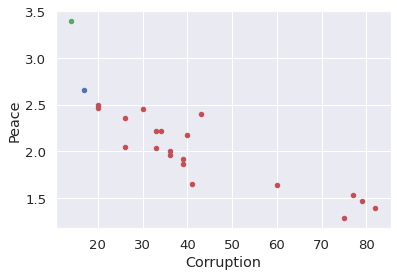

In [ ]:
agg = AgglomerativeClustering(n_clusters=3, linkage='average').fit(scaled_input)

ax = plt.gca()
df[agg.labels_==0][:20].plot.scatter(x='Corruption', y='Peace', color='r', ax=ax)
df[agg.labels_==1][:20].plot.scatter(x='Corruption', y='Peace', color='g', ax=ax)
df[agg.labels_==2][:20].plot.scatter(x='Corruption', y='Peace', color='b', ax=ax)

df[agg.labels_==1]


# distribution-based clustering

$L = \sum_{i=1}^n ln(\sum_{k=1}^K a_k N(x_i|\mu_k, \sum_k))$ (這整個 dataset 被 目前的 gaussian mixture sample 出來的 log-likelihood)<br><br>
上式的 $ln$ 內有 $\sum$ <br>
=> 因為每個 $x_i$ 都不知道是哪個 distribution 所 sample 出來的<br>
=> 引入一個 latent variable $z_i, z_1: x_1$所屬的distribution(soft clustering)<br>
$L = \sum_{i=1}^N ln(\sum_{z_i} f(x_i, z_i|\theta))$<br>
&nbsp;&nbsp;&nbsp;&nbsp;
$= \sum_{i=1}^N ln(\sum_{z_i} q(z_i) \frac{f(x_i, z_i|\theta)}{q(z_i)})$<br>
&nbsp;&nbsp;&nbsp;&nbsp;
$= \sum_{i=1}^N ln(E_{z_i \sim q(z_i)}[X])$ <br>
&nbsp;&nbsp;&nbsp;&nbsp;
$\geq \sum_{i=1}^N E_{z_i \sim q(z_i)} [ln(X)]$ <br>
&nbsp;&nbsp;&nbsp;&nbsp;
$ = \sum_{i=1}^N \sum_{z_i} q(z_i) ln(\frac{f(x_i, z_i|\theta)}{q(z_i)}) $

=> $q(z_i) = p(z_i = k|x_i) = \frac{a_k N(x_i|\mu_k, \sum_k)}{\sum_{k=1}^K a_k N(x_i|\mu_k, \sum_k)} = w_k(x_i)$<br>
$L^{t+1} = \sum_{i=1}^n ln(\sum_{k=1}^K w_k^t(x_i) \frac{a_k^{t+1} N(x_i^{t+1}|\mu_k^{t+1}, \sum_k^{t+1})}{w_k^t(x_i)})$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$\geq \sum_{i=1}^n \sum_{k=1}^K w_k^t(x_i) ln(\frac{a_k^{t+1} N(x_i^{t+1}|\mu_k^{t+1}, \sum_k^{t+1})}{w_k^t(x_i)})$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$= \sum_{i=1}^n \sum_{k=1}^K w_k^t(x_i) ln({a_k^{t+1} N(x_i^{t+1}|\mu_k^{t+1}, \sum_k^{t+1})}) + C$ (lower bound)<br>

EM step: find $a_k, \mu_k, \sum_k$ s.t. Objective is approximately maximized

E step: cal $w_j(x_i)$ given $\mu_j, \sum_j, a_j, \forall j $ <br>

M step: 對 $L^{t+1}$ 的 $lower bound$ 分別對參數做偏微分=0
* $a_k^{t+1} = \frac{n_k^t}{n}, n_k^t = \sum_{i=1}^n w_k^t(x_i)$ <br><br>
* $\mu_k^{t+1} = \frac{1}{n_k^t}\sum_{i=1}^n w_k^t(x_i)x_i$ <br><br>
* $\sum_k^{t+1} = \frac{1}{n_k^t}\sum_{i=1}^n\sum_{k=1}^K w_k^t(x_i)(x_i - \mu_k^{t+1})(x_i - \mu_k^{t+1})^T$ <br><br>

In [ ]:
from FinMind.Data import Load

target = {
    'USStockPrice': ['^GSPC', '^DJI', '^IXIC', 'Adj_Close'],
    # 'TaiwanStockPrice': ['TAIEX', 'close']
}

index_data = {}

for t in target:
    for n in target[t][:-1]:
        index_data[n] = Load.FinData(t, select=n, date='2012-01-01').set_index('date')[target[t][-1]]

    index_df = pd.DataFrame(index_data).ffill().copy()
index_return_df = index_df.pct_change().dropna()*100
index_return_df.head()

,^GSPC,^DJI,^IXIC
date,,,
2012-01-04,0.018793,0.169390,-0.013591
2012-01-05,0.294371,-0.021742,0.811823
2012-01-06,-0.253696,-0.449431,0.163304
2012-01-09,0.226168,0.265374,0.087502
2012-01-10,0.888577,0.563235,0.969154


means: 
 [[-0.83702257 -0.73204773 -0.94895814]
 [ 0.0032573  -0.00517603  0.03070395]
 [ 0.53562434  0.48795659  0.54159317]]
cov_mat: 
 [[[2.76289408 2.84198753 2.44570289]
  [2.84198753 3.02376166 2.45298626]
  [2.44570289 2.45298626 2.37464394]]

 [[0.25754983 0.23758882 0.25127499]
  [0.23758882 0.2521627  0.21129499]
  [0.25127499 0.21129499 0.30364596]]

 [[0.91815198 0.87259588 0.86997332]
  [0.87259588 0.91755935 0.78791226]
  [0.86997332 0.78791226 0.91970281]]]
sqrt(det(cov_mat)):  [0.21751, 0.01971, 0.07962]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  0 -1 -1 -1  1 -1
  1 -1 -1 -1  1  0  1  1 -1  1 -1 -1  0  1 -1  1  1  1 -1 -1  1  0 -1 -1
  1  0  0 -1 -1  1  1  0  1 -1  0 -1  1 -1 -1 -1 -1  0  1  0  0  0  0  0
 -1  1 -1 -1  1  1  0  1 -1  1 -1  1 -1 -1  1  0  1 -1 -1  0 -1  0  1 -1
  1  1  1  1  0  1  0 -1 -1 -1  1  0  0  1  1  0  0  1  1  1  1  0  0  1
  1 -1 -1  0 -1  1 -1 -1  1  1 -1  0 -1 -1  1 -1  0  1  1  0  1  1 -1  1
 -1  1  1  1  1  0  0  0  0 -1  0  0

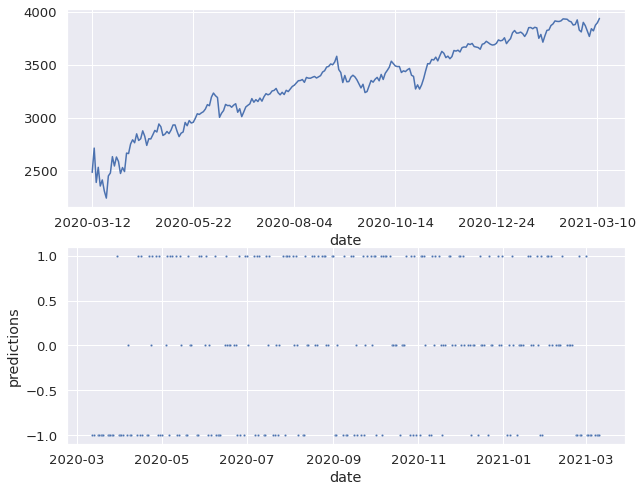

,^GSPC,^DJI,^IXIC
date,,,
2020-03-12,-9.511,-9.988,-9.435
2020-03-13,9.287,9.363,9.346
2020-03-16,-11.984,-12.927,-12.321
2020-03-17,5.995,5.196,6.230
2020-03-18,-7.010,-7.819,-6.304
2020-03-19,2.444,2.607,4.048
2020-03-20,-4.336,-4.546,-3.791
2020-03-23,-2.929,-3.036,-0.274
2020-03-24,9.383,11.365,8.122


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import mixture
from sklearn.pipeline import make_pipeline

X_train = index_return_df.iloc[:-252, :]
X_test = index_return_df.iloc[-252:, :]

pipe = make_pipeline(StandardScaler(), mixture.GaussianMixture(n_components=3, random_state=3))
pipe.fit(X_train)
predictions = pipe.predict(X_test)
idx = np.argsort(pipe.named_steps['gaussianmixture'].means_.sum(axis=1))
print("means: \n", pipe.named_steps['gaussianmixture'].means_[idx])
print("cov_mat: \n", pipe.named_steps['gaussianmixture'].covariances_[idx])
print("sqrt(det(cov_mat)): ", [(np.linalg.det(c)**0.5).round(5) for c in pipe.named_steps['gaussianmixture'].covariances_[idx]])
args = []
for i in idx:
    args.append(np.where(predictions == i)[0])
for i, arg in enumerate(args):
    predictions[arg] = i-1
print(predictions)
predictions_df = pd.DataFrame(predictions, index=X_test.index, columns=['predictions']).reset_index()
predictions_df['date'] = pd.to_datetime(predictions_df['date'])
f, axes = plt.subplots(2, 1, figsize=(10, 8))
index_df.iloc[-252:, :]['^GSPC'].plot(ax=axes[0])
sns.scatterplot(x='date', y='predictions', data=predictions_df, s=5, ax=axes[1])
plt.show()
display_side_by_side([X_test.iloc[:30].round(3), predictions_df.set_index('date').iloc[:30]])

In [ ]:
def sliding_window(data, history_size=42, test_size=1):
    train, test = [], []
    stop = len(data)-(test_size-1)-history_size
    remainder = stop % test_size
    for i in range(0, stop, test_size):
        train.append(data[i:i+history_size].reshape(1, history_size, -1))
        test.append(data[i+history_size:i+history_size+test_size].reshape(1, test_size, -1))
        if (i + test_size) >= stop and remainder:
            train.append(data[i+remainder:i+remainder+history_size].reshape(1, history_size, -1))
            arr = np.empty((1, test_size, data.shape[-1]))
            arr[:] = np.NaN
            arr[0, :remainder] = data[i+remainder+history_size:i+2*remainder+history_size].reshape(1, remainder, -1)
            test.append(arr)
    return np.vstack(train), np.vstack(test)

X_train, X_test = sliding_window(index_return_df.values, history_size=42, test_size=1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import mixture
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(StandardScaler(), mixture.GaussianMixture(n_components=3, random_state=3))

predictions = []
for train, test in zip(X_train, X_test):
    pipe.fit(train)
    idx = np.argsort(pipe.named_steps['gaussianmixture'].means_.sum(axis=1))
    mask = np.all(np.isnan(test), axis=1)
    test = test[~mask]
    p = pipe.predict(test)
    for i in range(3):
        p[np.where(p == idx[i])[0]] = i-1
    predictions = np.hstack([predictions, p])

In [ ]:
predictions_series = pd.Series(predictions, index=index_df.index[42+1:])
predictions_series

date
2012-03-06    1.0
2012-03-07    1.0
2012-03-08    1.0
2012-03-09    1.0
2012-03-12    1.0
             ... 
2021-03-05    0.0
2021-03-08    1.0
2021-03-09    1.0
2021-03-10    0.0
2021-03-11    1.0
Length: 2269, dtype: float64

In [ ]:
index_df['predictions'] = predictions_series
taiex_for_plt = index_df.reset_index()
taiex_for_plt['date'] = pd.to_datetime(taiex_for_plt['date'])

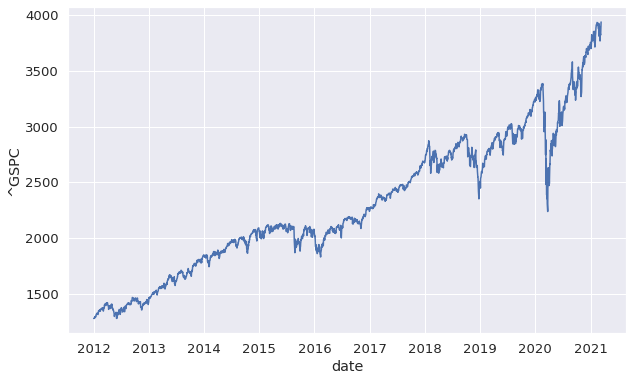

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='^GSPC', data=taiex_for_plt)
plt.show()

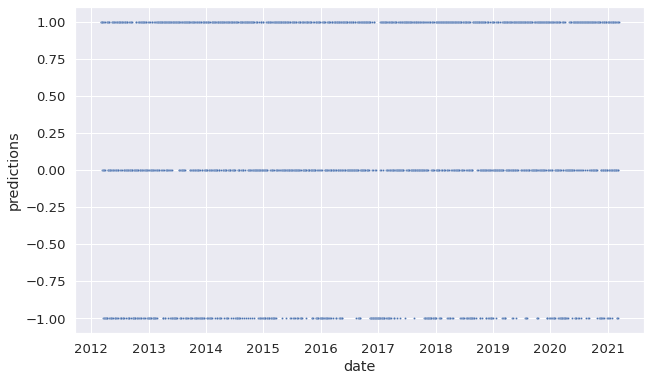

In [ ]:
plt.figure(figsize=(10.2, 6))
sns.scatterplot(x='date', y='predictions', data=taiex_for_plt, s=4)
plt.show()

In [ ]:
display_side_by_side([taiex_for_plt.dropna().iloc[4:34],
                      taiex_for_plt.dropna().iloc[:34][['predictions']].rolling(5).sum().dropna()])


,date,^GSPC,^DJI,^IXIC,predictions
47,2012-03-12,1371.09,12959.7,2983.66,1.0
48,2012-03-13,1395.95,13177.7,3039.88,1.0
49,2012-03-14,1394.28,13194.1,3040.73,0.0
50,2012-03-15,1402.60,13252.8,3056.37,0.0
51,2012-03-16,1404.17,13232.6,3055.26,0.0
52,2012-03-19,1409.75,13239.1,3078.32,1.0
53,2012-03-20,1405.52,13170.2,3074.15,-1.0
54,2012-03-21,1402.89,13124.6,3075.32,0.0
55,2012-03-22,1392.78,13046.1,3063.32,0.0
56,2012-03-23,1397.11,13080.7,3067.92,-1.0


Exercise 2.13

In [ ]:
pd.DataFrame(kmeans_three_features.cluster_centers_, columns=three_features_input.columns, index=['high', 'low', 'moderate'])

,Peace,Legal,GDP Growth
high,1.397830,-1.046003,-1.801892
low,-0.931933,1.171223,-0.014518
moderate,0.260407,-0.473601,0.379518


In [ ]:
original_input = df[['Corruption', 'Peace', 'Legal', 'GDP Growth']]
scaled_input = scaler.fit_transform(original_input)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=3).fit(scaled_input)
pd.DataFrame(kmeans.cluster_centers_, columns=original_input.columns, index=['moderate', 'low', 'high'])

,Corruption,Peace,Legal,GDP Growth
moderate,-1.027467,1.352217,-1.059033,-1.719983
low,1.231352,-0.979187,1.165956,0.010270
high,-0.479569,0.263309,-0.435100,0.373518


In [ ]:
display_side_by_side([df[kmeans.labels_ == 2][['Country']],
                      df[kmeans_three_features.labels_ == 2][['Country']]],
                      names=['4 features', '3 features'])

4 features,3 features
,Country
0,Albania
1,Algeria
3,Armenia
7,Bahrain
8,Bangladesh
10,Benin
11,Bolivia
12,Bosnia and Herzegovina
15,Bulgaria


# Density-Based Clustering

given MinPts(m), epsilon ($\epsilon$)

* core points: <br>
    $|N_\epsilon(q)| \geq m$

* border points: <br>
    $|N_\epsilon(p)| < m$ <br>
    $p \in N_\epsilon(q), $ q is a core point

* noise: <br>
    neither of the above
----------------------
1. mark all points

2. ignore noise points

3. $\forall$ core points $c_k,$<br>
   $\forall$ core points $c_j, j \neq k$<br>
   if $dist(c_j, c_k) < \epsilon$ : form_a_group($c_j, c_k$)

4. $\forall$ border points $c_b$ <br>
   $\forall$ core points $c_k$ <br>
   if $dist(c_b, c_k) < \epsilon$ : form_a_group($c_b, c_k$)

Q: 如果有個 border point, 對應於兩個核心點, 但那兩個核心點又不同群, 怎麼歸類？ <br>
A: 誰先判斷就歸哪類 => not stable

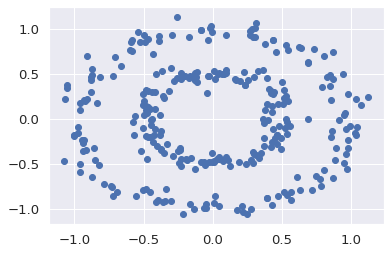

In [ ]:
from sklearn.datasets import make_blobs, make_circles
circles, c_labels = make_circles(n_samples=300, noise=.07, factor=.5, random_state=3)
plt.scatter(circles[:, 0], circles[:, 1])
plt.show()


In [ ]:
from sklearn.cluster import DBSCAN

def get_label_color_mapping(model, X):
    model.fit(X)
    labels = model.labels_
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    return zip(unique_labels, colors)

db = DBSCAN(eps=.2)
km = KMeans(n_clusters=2)
db_mapping = get_label_color_mapping(db, circles)
km_mapping = get_label_color_mapping(km, circles)

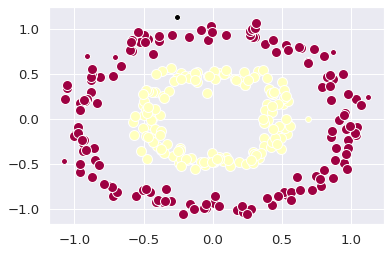

In [ ]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
for k, col in db_mapping:
    if k == -1:
        col = [0, 0, 0, 1]
    class_member_mask = (db.labels_ == k)
    xy = circles[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='w', markersize=10)

    xy = circles[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='w', markersize=6)


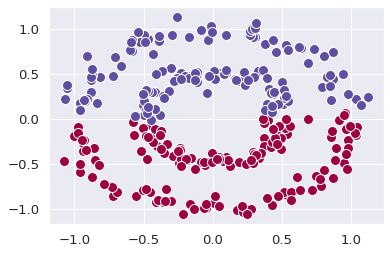

In [ ]:
for k, col in km_mapping:
    class_member_mask = (km.labels_ == k)
    xy = circles[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='w', markersize=10)


In [ ]:
new_2019_country_risk = DataLoader.load_data('new_2019_country_risk_url')

In [ ]:
new_2019_country_risk.head()

,NaN,Corruption,Peace,Legal,GDP Growth
0,Albania,35,1.821,4.546,2.983
1,Algeria,35,2.219,4.435,2.553
2,Argentina,45,1.989,5.087,-3.061
3,Armenia,42,2.294,4.812,6.000
4,Australia,77,1.419,8.363,1.713


In [ ]:
new_2019_country_risk.columns = ["Country"] + list(new_2019_country_risk.columns[1:])
new_2019_country_risk.head()

,Country,Corruption,Peace,Legal,GDP Growth
0,Albania,35,1.821,4.546,2.983
1,Algeria,35,2.219,4.435,2.553
2,Argentina,45,1.989,5.087,-3.061
3,Armenia,42,2.294,4.812,6.000
4,Australia,77,1.419,8.363,1.713


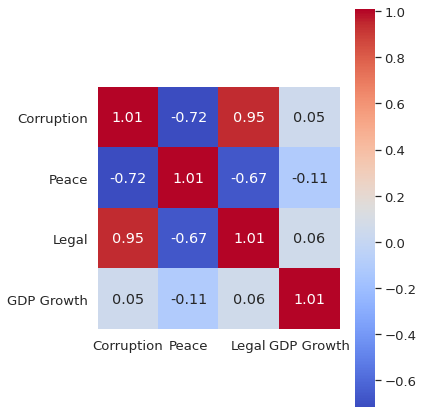

In [ ]:
cols = new_2019_country_risk.columns[1:]
cov_matrix = np.cov(StandardScaler().fit_transform(new_2019_country_risk[cols]).T)
draw_cov_heatmap(cov_matrix, cols)

In [ ]:
new_features = new_2019_country_risk[['Peace', 'Legal', 'GDP Growth']]
new_scaled_features = scaler.fit_transform(new_features)

In [ ]:
new_kmeans = KMeans(n_clusters=3, random_state=3).fit(new_scaled_features)
pd.DataFrame(new_kmeans.cluster_centers_, columns=new_features.columns, index=['moderate', 'low', 'high'])

,Peace,Legal,GDP Growth
moderate,0.502901,-0.581378,0.143216
low,-0.912789,1.063859,-0.050518
high,1.439365,-2.043678,-8.804819


In [ ]:
round(silhouette_score(new_scaled_features, new_kmeans.labels_), 3)

0.406

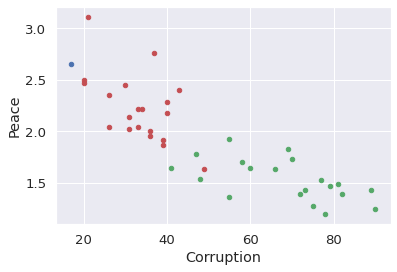

In [ ]:
ax = plt.gca()
df[new_kmeans.labels_==0][:20].plot.scatter(x='Corruption', y='Peace', color='r', ax=ax)
df[new_kmeans.labels_==1][:20].plot.scatter(x='Corruption', y='Peace', color='g', ax=ax)
df[new_kmeans.labels_==2][:20].plot.scatter(x='Corruption', y='Peace', color='b', ax=ax)

In [ ]:
display_side_by_side([df[new_kmeans.labels_ == 2][['Country']], 
                      df[kmeans_three_features.labels_ == 2][['Country']]],
                      names=['new kmeans', '3 features kmeans'])

new kmeans,3 features kmeans
,Country
117,Venezuela
,Country
0,Albania
1,Algeria
3,Armenia
7,Bahrain
8,Bangladesh
10,Benin
11,Bolivia
